In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3

# Membuat koneksi ke database SQLite
conn = sqlite3.connect('database.db')

In [ ]:
# Load dataset from database
import pandas as pd

db = sqlite3.connect('database.db', check_same_thread = False)
q_data = 'SELECT * FROM tabel_cleansed'
data = pd.read_sql_query(q_data, db)
data.head()

,text,label
0,warung dimiliki pengusaha pabrik tahu puluhan ...,positive
1,mohon ulama lurus k mmbri hujjah pak ai apa ha...,neutral
2,lokasi strategis jalan sumatra bandung tempat ...,positive
3,betapa bahagia diri unboxing paket barang bagu...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


## Feature-Label Classification

In [ ]:
neg = data.loc[data.label == 'negative'].text.tolist()
neu = data.loc[data.label == 'neutral'].text.tolist()
pos = data.loc[data.label == 'positive'].text.tolist()

neg_label = data.loc[data.label == 'negative'].label.tolist()
neu_label = data.loc[data.label == 'neutral'].label.tolist()
pos_label = data.loc[data.label == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


# Feature Extraction

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

In [ ]:
# Tokenizer and pad sequence

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [ ]:
# Feature extraction for labels

Y = pd.get_dummies(labels,  dtype=int)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# Split traning and testing dataset

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.keras import balanced_batch_generator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from keras import regularizers

In [ ]:
# Split train-test data with proportion 80:20

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model Training

### Training

In [ ]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(3,activation='softmax'))

adam = optimizers.Adam(learning_rate = 0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
137/137 [==============================] - 61s 413ms/step - loss: 0.8839 - accuracy: 0.7122 - val_loss: 0.6282 - val_accuracy: 0.7663
Epoch 2/10
137/137 [==============================] - 54s 391ms/step - loss: 0.4843 - accuracy: 0.8347 - val_loss: 0.4735 - val_

### Evaluasi

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

predictions = model.predict(X_test)
y_pred = predictions
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(y_test, axis=1)
matrix_test = metrics.classification_report(Y_test_classes, y_pred_classes)
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 15ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       681
           1       0.87      0.62      0.72       235
           2       0.93      0.90      0.91      1271

    accuracy                           0.87      2187
   macro avg       0.86      0.80      0.82      2187
weighted avg       0.87      0.87      0.87      2187



69/69 [==============================] - 1s 15ms/step


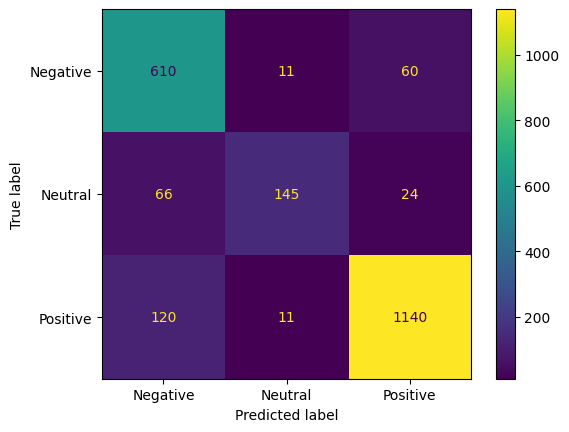

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sentiment = ['Negative', 'Neutral', 'Positive']
prediction = model.predict(X_test)
y_pred = prediction
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sentiment)

disp.plot()
plt.grid(False)
plt.show()

### Cross validation

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.002)))
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(learning_rate = 0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy *100)

Epoch 1/10
137/137 [==============================] - 58s 401ms/step - loss: 0.8707 - accuracy: 0.7017 - val_loss: 0.6054 - val_accuracy: 0.7755
Epoch 2/10
137/137 [==============================] - 53s 386ms/step - loss: 0.4859 - accuracy: 0.8219 - val_loss: 0.4446 - val_accuracy: 0.8583
Epoch 3/10
137/137 [==============================] - 52s 380ms/step - loss: 0.3198 - accuracy: 0.9169 - val_loss: 0.4086 - val_accuracy: 0.8679
Epoch 4/10
137/137 [==============================] - 50s 366ms/step - loss: 0.2307 - accuracy: 0.9410 - val_loss: 0.3927 - val_accuracy: 0.8738
Epoch 5/10
137/137 [==============================] - 52s 380ms/step - loss: 0.1756 - accuracy: 0.9574 - val_loss: 0.4180 - val_accuracy: 0.8720
Epoch 5: early stopping
69/69 [==============================] - 1s 15ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       681
           1       0.83      0.68      0.75       235
           2       

### Evaluation Visualization

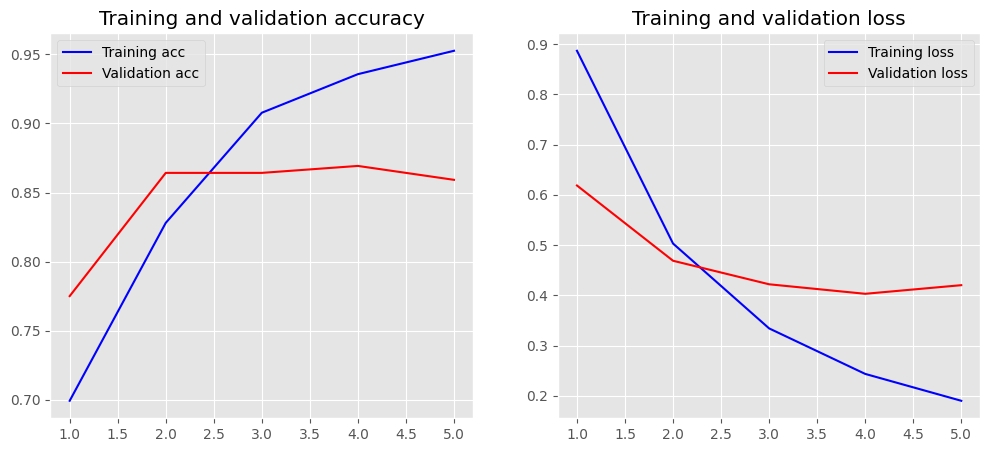

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
model.save('model_lstm.h5')
print("Model has created!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


# Prediction

In [ ]:
import re
from keras.models import load_model
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
df_alay = pd.read_csv('new_kamusalay.csv', encoding='ISO-8859-1', header=None)
df_alay = df_alay.rename(columns={0: 'alay', 1: 'formal'})
df_alay_dict = dict(zip(df_alay['alay'], df_alay['formal']))

In [ ]:
def case_folding (text):
    return text.lower()

def clean (text):
    clean1 = re.sub ('\\n','', text)
    clean2 = re.sub ('RT',' ', clean1)
    clean3 = re.sub ('USER', ' ', clean2)
    clean4 = re.sub ('(http|https):\/\/s+', ' ', clean3)
    clean5 = re.sub ('[^0-9a-zA-Z]+', ' ', clean4)
    clean6 = re.sub ('x[a-z0-9]{2}', ' ', clean5)
    clean7 = re.sub ("\d+", ' ', clean6)
    clean8 = re.sub ('  +', '', clean7)
    clean9 = re.sub ('user', ' ', clean8)
    return clean9

def tokenization(text):
    text = re.split('\W+', text)
    return text

def alay_normalization(text):
    newlist = []
    for word in text:
        if word in df_alay_dict:
            text = df_alay_dict[word]
            newlist.append(text)
        else:
            text = word
            newlist.append(text)
    return newlist

#stopwords
stopword_list = ["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                 'yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia',
                  'ia', 'seperti', 'jika', 'sehingga', 'kembali', 'dan', 'ini', 'karena', 'kepada', 'oleh',
                  'saat', 'sementara', 'setelah', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah',
                  'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bahwa', 'atau', 'kita', 'dengan',
                  'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda',
                  'kalo', 'amp', 'biar', 'bikin', 'bilang', 'si', 'tau', 'tdk', 'tuh', 'utk', 'ya','kayak', 'i', 'a',
                  'gak', 'ga', 'krn', 'nya', 'nih', 'sih','jd', 'jgn', 'sdh', 'aja', 'n', 't', 'gue', 'yah',
                 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang',
                  'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun',
                  'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'seolah', 'seraya',
                  'seterusnya', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'mari', 'nanti', 'oh', 'ok',
                  'setiap', 'sesuatu','saja', 'toh', 'walau', 'amat', 'apalagi', 'dengan', 'bahwa', 'oleh']

stopword_list = set(stopword_list)

def remove_stopwords(text):
    text = [word for word in text if word not in stopword_list]
    return text

def clean_non_existed(text):
    if text == '':
        return None
    else:
        return text

#jadikan satu fungsi cleansing
def cleansing(text):
    text = case_folding(text)
    text = clean(text)
    text = tokenization(text)
    text = alay_normalization(text)
    text = remove_stopwords(text)
    text = ' '.join(text)
    text = clean_non_existed(text)
    return text

In [ ]:
input_text = """
selamat pagi """

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 1s 596ms/step
Text:  selamat pagi
Sentiment: neutral


In [ ]:
input_text = """
tempat itu bagus banget """

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 262ms/step
Text:  tempat bagus banget
Sentiment: positive


In [ ]:
input_text = """
TEMPAT ITU JELEK, SAYA ENGGA SUKA TAU """

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 430ms/step
Text:  tempat jelek tidak suka
Sentiment: negative


# **Prediksi Data Tweet**

In [ ]:
data_twt = 'data.csv'
df_tweet = pd.read_csv(data_twt, encoding='latin-1')

In [ ]:
df_predict = df_tweet[['Tweet']].copy()
df_predict.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


In [ ]:
sentiment = ['negative', 'neutral', 'positive']

def get_sent(sent):
    if sent==0:
        sent='negative'
    elif sent==1:
        sent='neutral'
    else: sent='positive'
    return sent

file_tokenizer = open('tokenizer.pickle', 'rb')
file_sequencer = open('x_pad_sequences.pickle', 'rb')
load_tokenizer = pickle.load(file_tokenizer)
load_sequencer = pickle.load(file_sequencer)
file_sequencer.close()
model_lstm = load_model('model_lstm.h5')

In [ ]:
df_predict['text_clean'] = df_predict.apply(lambda row : cleansing(row['Tweet']), axis = 1)

In [ ]:
df_predict.head()

,Tweet,text_clean
0,- disaat semua cowok berusaha melacak perhatia...,di saat semua cowok berusaha melacak perhatian...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa telat memberi kamu edan sarap bergaul ci...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang aku berpikir aku tetap percaya tuhan pa...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku aku matamu sipit tapi dilihat mana aku
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir kelihatan dongoknya awal tam...


In [ ]:
df_predict['text_clean'].isnull().sum()  # Check for the number of missing values

46

In [ ]:
df_predict = df_predict.dropna(subset=['text_clean'])

In [ ]:
df_predict['text_clean'].isnull().sum()  # Check for the number of missing values

0

In [ ]:
# Tokenize and pad sequences
feature = load_tokenizer.texts_to_sequences(df_predict['text_clean'])
sequences = pad_sequences(feature, maxlen=load_sequencer.shape[1])

# Make predictions
predictions = model_lstm.predict(sequences)

# Convert predictions to sentiment labels using get_sent function
predicted_sentiments = [get_sent(np.argmax(prediction)) for prediction in predictions]

# Add the 'sentiment' column to the DataFrame
df_predict['sentiment'] = predicted_sentiments

411/411 [==============================] - 11s 27ms/step


<ipython-input-38-150612821103>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['sentiment'] = predicted_sentiments


In [ ]:
df_predict.head()

,Tweet,text_clean,sentiment
0,- disaat semua cowok berusaha melacak perhatia...,di saat semua cowok berusaha melacak perhatian...,neutral
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa telat memberi kamu edan sarap bergaul ci...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang aku berpikir aku tetap percaya tuhan pa...,positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku aku matamu sipit tapi dilihat mana aku,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir kelihatan dongoknya awal tam...,negative


<ipython-input-43-83f26a0d80b0>:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.countplot(x='sentiment', data=df_predict, palette=color_palette, hue='sentiment', order=sentiment_order, legend=False)


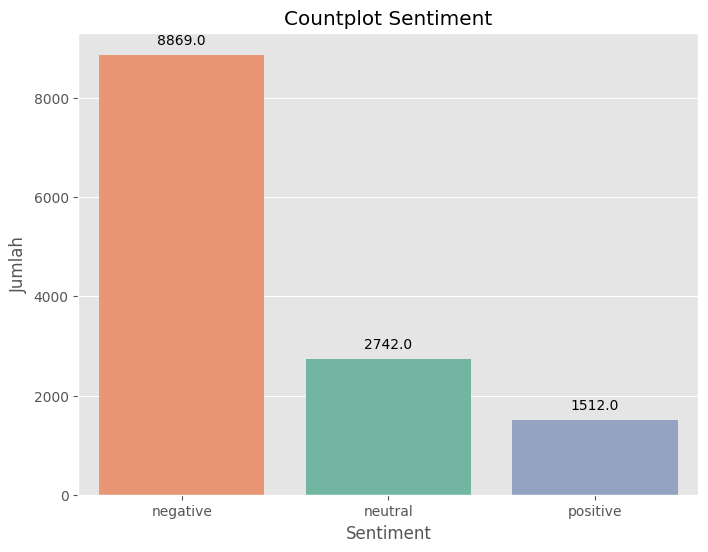

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data frame df_predict harus sudah ada sebelumnya

# Menentukan urutan sentimen berdasarkan jumlah dari yang paling banyak ke paling sedikit
sentiment_order = df_predict['sentiment'].value_counts().index

# Mengatur palet warna
color_palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 6), facecolor='w')  # Menambahkan properti facecolor dengan nilai 'w' (putih)
ax = sns.countplot(x='sentiment', data=df_predict, palette=color_palette, hue='sentiment', order=sentiment_order, legend=False)

# Menambahkan label angka pada setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menambahkan label sumbu dan judul
plt.xlabel('Sentiment')
plt.ylabel('Jumlah')
plt.title('Countplot Sentiment')

# Menampilkan plot
plt.show()

In [ ]:
# Menyimpan hasil prediksi ke dalam database SQLite
import sqlite3

conn = sqlite3.connect('sentiment_predictions.db')

# Sesuaikan dengan nama tabel yang sesuai dengan kebutuhan Anda.
df_predict.to_sql('sentiment_predictions', con=conn, index=False, if_exists='replace')

# Tutup koneksi setelah selesai
conn.close()